In [1]:
!date

Wed Feb 16 17:06:28 PST 2022


# Cluster-wise comparison between control and experiment datasets
# Confirming that t-test and wilcoxon yield same results -> wilcoxon
Clustering performed on pooled data.
#### Unfiltered data obtained from using kb with multimapping function. Ref genome includes WRE.

___

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext blackcellmagic

In [3]:
import sys
import anndata
# import scvi

import scanpy as sc
import numpy as np
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd

sc.set_figure_params(figsize=(6, 6), frameon=False)
sc.settings.n_jobs=2

In [4]:
# set random seed
np.random.seed(926)

In [5]:
def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

___

# Load AnnData object

In [6]:
adata = anndata.read_h5ad("../../finchseq_data/all_celltype.h5ad")
adata

AnnData object with n_obs × n_vars = 35804 × 22151
    obs: 'species', 'batch', 'n_counts_processed', 'batch_index', 'n_counts_raw', 'leiden', 'celltype', 'connectivity'
    var: 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Define masks to separate control and experiment datasets:

In [7]:
control_mask = np.logical_or(adata.obs["batch"]=="control1", adata.obs["batch"]=="control2")
experiment_mask = np.logical_or(adata.obs["batch"]=="experiment1", adata.obs["batch"]=="experiment2")

Add new obs column to separate between control and experiment in general, without separating between batches:

In [8]:
adata.obs["batch_g"] = ""

adata.obs.loc[control_mask, "batch_g"] = "control"
adata.obs.loc[experiment_mask, "batch_g"] = "experiment"

adata.obs

,species,batch,n_counts_processed,batch_index,n_counts_raw,leiden,celltype,connectivity,batch_g
barcode,,,,,,,,,
AAACCCAAGCACTGGA-0,zebrafinch,control1,483.000000,0,483.000000,13,mural cells 2,0,control
AAACCCAAGCGTCAAG-0,zebrafinch,control1,946.000061,0,946.000061,3,microglia 1,1,control
AAACCCAAGGTCACAG-0,zebrafinch,control1,1068.000000,0,1068.000000,1,GABAergic neurons 1,2,control
AAACCCAAGTCATTGC-0,zebrafinch,control1,1407.000000,0,1407.000000,10,astrocytes 2,3,control
AAACCCAAGTGCTACT-0,zebrafinch,control1,1060.000000,0,1060.000000,1,GABAergic neurons 1,2,control
...,...,...,...,...,...,...,...,...,...
TTTGTTGTCAACTCTT-3,zebrafinch,experiment2,791.999939,3,791.999939,0,glutamatergic neurons 1,undefined 1,experiment
TTTGTTGTCGATCCAA-3,zebrafinch,experiment2,4345.000000,3,4345.000000,2,migrating neuroblasts,9,experiment
TTTGTTGTCTAGATCG-3,zebrafinch,experiment2,1352.000000,3,1352.000000,6,mural / vascular endothelial cells 1,6,experiment


___

# Find DE genes filtered based on fold change and expression inside/outside group

Set filters:  
min_fold_change = Minimum fold change between mean gene expression between control and experiment.  
min_in_group_fraction = Minimum percentage of cells inside the cluster of interest that express the gene.  
max_out_group_fraction = Maximum percentage of cells outside the cluster of interest that express the gene.

In [9]:
min_fold_change = 1.5
min_in_group_fraction = 0.25   
max_out_group_fraction = 1  

In [10]:
# Display all clusters
np.sort(adata.obs.celltype.values.unique())

array(['GABAergic neurons 1', 'GABAergic neurons 2',
       'GABAergic neurons 3', 'astrocytes 1', 'astrocytes 2',
       'glutamatergic neurons 1', 'glutamatergic neurons 2',
       'glutamatergic neurons 3', 'glutamatergic neurons 4',
       'microglia 1', 'microglia 2', 'microglia 3 / radial glia',
       'migrating neuroblasts', 'mural / vascular endothelial cells 1',
       'mural cells 2', 'oligodendrocyte precursor cells',
       'oligodendrocytes 1', 'oligodendrocytes 2', 'oligodendrocytes 3',
       'radial glia 1', 'radial glia 2', 'red blood cells'], dtype=object)

In [11]:
# Empty arrays to store DE genes
DE_ctrl = []
DE_exp = []

# Define clusters to be searched for DE genes
clusters = [
    "GABAergic neurons 1",
    "GABAergic neurons 2",
    "astrocytes 1",
    "astrocytes 2",
    "glutamatergic neurons 1",
    "glutamatergic neurons 2",
    "glutamatergic neurons 3",
    "glutamatergic neurons 4",
    "microglia 1",
    "microglia 2",
]

for cluster in clusters:
    adata_temp = adata[
        np.char.startswith(nd(adata.obs.celltype.values).astype(str), cluster)
    ]

    # Find DE genes comparing experiment and control for this one cluster
    sc.tl.rank_genes_groups(adata_temp, 
                            groupby="batch_g", 
                            use_raw=False,
                            method="wilcoxon"
                           )

    # Apply filters
    sc.tl.filter_rank_genes_groups(
        adata_temp,
        use_raw=False,
        min_fold_change=min_fold_change,
        min_in_group_fraction=min_in_group_fraction,
        max_out_group_fraction=max_out_group_fraction,
    )
    # Get all DE genes that fit filter
    DE_genes = pd.DataFrame(adata_temp.uns["rank_genes_groups_filtered"]["names"])
    DE_genes_ctrl = DE_genes["control"].values
    DE_genes_exp = DE_genes["experiment"].values

    # Filter out NaN values (if less than 20 genes were found)
    DE_genes_ctrl = DE_genes_ctrl[~pd.isna(DE_genes_ctrl)]
    DE_genes_exp = DE_genes_exp[~pd.isna(DE_genes_exp)]

    # Store in arrays
    DE_ctrl.append(DE_genes_ctrl)
    DE_exp.append(DE_genes_exp)

# Concatenate arrays into one array
DE_ctrl = np.concatenate(DE_ctrl)
DE_exp = np.concatenate(DE_exp)

/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'batch_g' as categorical
/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'batch_g' as categorical
/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'batch_g' as categorical
/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: Implic

In [13]:
# Keep each gene only once without alphabetic sorting
indeces = np.unique(DE_ctrl, return_index=True)[1]
DE_ctrl = [DE_ctrl[index] for index in sorted(indeces)]

indeces_exp = np.unique(DE_exp, return_index=True)[1]
DE_exp = [DE_exp[index] for index in sorted(indeces_exp)]

In [17]:
ctrl_gene_names = [
    "Voltage-Gated Potassium Channel Subunit Beta-3-like",
    "Ribosomal Protein L17 (RPL17)",
    "Proteasome 20S Subunit Beta 5-like\n(PSMB5) (isoform 1?)",
    "Thyroid Stimulating Hormone Receptor (TSHR)",
    "Solute Carrier Family 3 Member 2-like (SLC3A2)",
    "WRE (transgene sequence)",
    "Proenkephalin (PENK)",    
    "Insulin Like Growth Factor 2 (IGF2)",    
    "Urotensin 2B (UTS2B)",
    "ENSTGUG00000019157 (novel protein-coding)",
    "Yippee Like 4 (YPEL4)",
    "Tubulin beta-7 chain",
    "Adenylosuccinate Synthase 1 (ADSS1)",    
    "G Protein-Coupled Receptor Kinase 5 (GRK5)",
    "Actin, cytoplasmic type 5",
    "CAMP Responsive Element Modulator (CREM)",
    "All-Trans Retinoic Acid Induced\nDifferentiation factor (ATRAID)",    
    "Optic atrophy 3 (OPA3) protein homolog",      
    "GDNF Family Receptor Alpha 1 (GFRA1)",
    "Single-Strand-Selective Monofunctional\n Uracil-DNA Glycosylase 1-like (SMUG1)",
    "ENSTGUG00000029247 (novel protein coding)",    
    "Pleckstrin Homology Domain Containing A3 (PLEKHA3)",   
    "Calponin 3 (CNN3)",
    "ENSTGUG00000025966\nSplicing factor, proline- and glutamine-rich-like",   
    "Cytochrome P450 Family 4 Subfamily V Member 2 (CYP4V2)",
    "ENSTGUG00000020132 (lncRNA)",
    "Plexin Domain Containing 1 (PLXDC1)",
    "PH Domain Containing Endocytic\nTrafficking Adaptor 2 (PHETA2)",    
    "Dual Specificity Phosphatase 23 (DUSP23)",    
    "ENSTGUG00000024659 (lncRNA)",
    "ENSTGUG00000025857 (lncRNA)"
]

df_DE_ctrl = pd.DataFrame()
df_DE_ctrl["gene_ID"] = DE_ctrl
df_DE_ctrl["gene_name"] = ctrl_gene_names
# Sort genes alphabetically 
df_DE_ctrl = df_DE_ctrl.sort_values("gene_name")
df_DE_ctrl.to_csv("CTRL_DE-genes_ind-clusters.csv")
df_DE_ctrl

,gene_ID,gene_name
14,_ENSTGUG00000004026.2,"Actin, cytoplasmic type 5"
12,ADSS1_ENSTGUG00000012901.2,Adenylosuccinate Synthase 1 (ADSS1)
16,_ENSTGUG00000029336.1,All-Trans Retinoic Acid Induced\nDifferentiati...
15,_ENSTGUG00000025735.1,CAMP Responsive Element Modulator (CREM)
22,CNN3_ENSTGUG00000005620.2,Calponin 3 (CNN3)
24,CYP4V2_ENSTGUG00000006924.2,Cytochrome P450 Family 4 Subfamily V Member 2 ...
28,DUSP23_ENSTGUG00000016440.2,Dual Specificity Phosphatase 23 (DUSP23)
9,_ENSTGUG00000019157.1,ENSTGUG00000019157 (novel protein-coding)
25,_ENSTGUG00000020132.1,ENSTGUG00000020132 (lncRNA)
29,_ENSTGUG00000024659.1,ENSTGUG00000024659 (lncRNA)


In [18]:
# exp_gene_names = [
#     "ENSTGUG00000017273\nClass I histocompatibility antigen,\nF10 α chain-like 1",    
#     "Ferritin (higher subunit)",    
#     "Clusterin (CLU)",    
#     "Proteasome 20S Subunit Beta 5-like\n(PSMB5) (isoform 2?)",
#     "Extracellular Fatty Acid-Binding\nProtein-like (EFABP)",   
#     "Apolipoprotein A1 (APOA1)",
#     "ENSTGUG00000028984\n(lncRNA)",
#     "ENSTGUG00000026593\n(lncRNA) NEW",
#     "ENSTGUG00000023200\n(lncRNA)",
#     "Small Nuclear Ribonucleoprotein G (SNRPG)",    
#     "Reprimo, TP53 Dependent G2 Arrest\nMediator Homolog (RPRM)",    
#     "Cordon-Bleu WH2 Repeat Protein Like 1 (COBLL1)",
#     "Interferon Alpha Inducible Protein 6 (IFI6)",
#     "Gamma-Aminobutyric Acid Type A Receptor Subunit Alpha1 (GABRA1)",
#     "Tubulin Beta 4B Class IVb (TUBB4B)",    
#     "Histamine Receptor H3 (HRH3)",
#     "WNT Inhibitory Factor 1 (WIF1)",
#     "ENSTGUG00000028243\n Predicted: Tubulin Beta chain",
#     "ENSTGUG00000027908\nBeta-Globin-like/Hemoglobin subunit rho",
#     "Complement C1r (C1R)",
#     "Neuronal Pentraxin 1 (NPTX1)",
#     "Beta-2-Microglobulin (B2M)",    
#     "Ectonucleotide Pyrophosphatase/\nPhosphodiesterase 2 (ENPP2)",
#     "Actin (cytoplasmic type 5)-like",
#     "ENSTGUG00000026632\n(lncRNA)",
#     "DDB1 and CUL4 Associated Factor 11-like (DCAF11)",
#     "Peroxisomal Biogenesis Factor 5 Like (PEX5L)",
#     "ENSTGUG00000020768 (lncRNA)\nHeterogeneous Nuclear\nRibonucleoprotein A1-like (HNRNPA1)",
#     "REST corepressor 2-like (RCOR2)",   
#     "Ras Protein Specific Guanine Nucleotide Releasing Factor 2 (RASGRF2)",
#     "Cyclin Dependent Kinase 5 Regulatory Subunit 1 (CDK5R1)",
#     "V-Set And Transmembrane Domain Containing 2B (VSTM2B)",
#     "Neogenin 1 (NEO1)",
#     "Tu Translation Elongation Factor, Mitochondrial (TUFM)",
#     "ENSTGUG00000023440\n (novel protein-coding) NEW",
#     "ENSTGUG00000022622\n (novel protein-coding) NEW",
#     "ENSTGUG00000026012\n (novel protein-coding) NEW",
#     "Myosin IB (MYO1B)",
#     "Basic salivary proline-rich protein 4-like",
#     "Reticulon-4 Receptor (RTN4R)",
#     "Lysine Acetyltransferase 5 (KAT5)",
#     "Unc-5 Netrin Receptor D (UNC5D)",
#     "ENSTGUG00000000022\n (novel protein-coding) NEW",
#     "ENSTGUG00000027876\n (novel protein-coding) NEW",
#     "ENSTGUG00000023202\n(lncRNA) NEW",
#     "ENSTGUG00000011634\n (novel protein-coding) NEW",
#     "ENSTGUG00000029519\n(lncRNA) NEW",
#     "Cdk5 And Abl Enzyme Substrate 2 (CABLES2)",
#     "ENSTGUG00000019706\n(lncRNA) NEW",
#     "THADA Armadillo Repeat Containing (THADA)",
#     "C-C Motif Chemokine 3-like (CCL3)",
#     "ENSTGUG00000026858 (lncRNA)\nFc fragment of IgE receptor Ig (FCER1G)", 
#     "HtrA Serine Peptidase 1 (HTRA1)",
#     "Ribosomal Protein S18-like (RPS18)",
#     "ENSTGUG00000028417\nClass I histocompatibility antigen,\nF10 α chain-like 2", 
#     "Ribosomal Protein L17 (RPL17)",
#     "Scinderin (SCIN)",
#     "HRAS-like suppressor-like",
#     "Tetraspanin 36-like (TSPAN36)",
#     "Capicua Transcriptional Repressor-like (CIC)",
#     "Serglycin (SRGN)",    
#     "ENSTGUG00000028479 (novel protein-coding)\n Maybe: Immunoglobulin Lambda-1 light chain-like",
#     "Ribosomal Protein S7 (RPS7)",
#     "Eukaryotic Translation Elongation Factor 1 Beta 2 (EEF1B2)",
#     "ENSTGUG00000000240\n T-cell receptor T3 delta chain",
#     "ENSTGUG00000003000\n Ig-like domain-containing protein",
#     "C-X-C Motif Chemokine Receptor 4 (CXCR4)",
#     "ENSTGUG00000019387\n (novel protein-coding) NEW",
#     "Ribosomal Protein L6 (RPL6)",
#     "NSA2 Ribosome Biogenesis Factor (NSA2)",
#     "Receptor For Activated C Kinase 1 (RACK1)",
#     "ENSTGUG00000000309\nKOW domain-containing protein",
#     "Patatin Like Phospholipase Domain Containing 2 (PNPLA2)",
#     "ENSTGUG00000020449\n (novel protein-coding) NEW",
#     "Cysteine Rich Protein 1 (CRIP1)",
#     "CD3E",
#     "Transgelin 2 (TAGLN2)",
#     "Regulator Of G Protein Signaling 1 (RGS1)"
# ]

# df_DE_exp = pd.DataFrame()
# df_DE_exp["gene_ID"] = DE_exp
# df_DE_exp["gene_name"] = exp_gene_names
# # Sort genes alphabetically 
# df_DE_exp = df_DE_exp.sort_values("gene_name")
# df_DE_exp.to_csv("EXP_DE-genes_ind-clusters.csv")
# df_DE_exp

___

# Violin plots

Define function to calculate fold change based on median instead of mean:

In [19]:
import numpy as np
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pandas as pd

def nd(arr):
    """
    Funciton to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

def violinplot(adata_exp, adata_ctrl, genes, labels, celltypes, fig_name, alpha=0.05, fold_change_min=2, figsize=None):
    if figsize == None:
        figsize = (len(celltypes)*2, len(genes))
        fig, axs = plt.subplots(figsize=figsize, nrows=len(genes))
    else:
        fig, axs = plt.subplots(figsize=figsize, nrows=len(genes))
    
    ## Find the indeces of the celltypes/clusters to be used
    # If the first celltype does not contain a number (e.g. "microglia" versus "microglia_1"),
    # use general celltype (celltype_g) to find all of the clusters for that celltye
    # (This is the case for data from the separately clustered dataset)
    if any(map(str.isdigit, celltypes[0])) == False:
        print("Bluk celltype analysis; including all clusters for each celltype (obs column: celltype_g).")
        # Define celltypes and celltype indeces in both datasets
        celltype_exp_idx = [np.where(adata_exp.obs.celltype_g == i)[0] for i in celltypes]
        celltype_ctrl_idx = [np.where(adata_ctrl.obs.celltype_g == i)[0] for i in celltypes]
    # Else, use individual clusters
    else:
        print("Individual cluster analysis (obs column: celltype).")
        # Define celltypes and celltype indeces in both datasets
        celltype_exp_idx = [np.where(adata_exp.obs.celltype == i)[0] for i in celltypes]
        celltype_ctrl_idx = [np.where(adata_ctrl.obs.celltype == i)[0] for i in celltypes]

    lidx = np.arange(len(celltypes))*2
    
    fontsize_star = 20

    for cidx, (gene, ax) in enumerate(zip(genes, axs)):
        ## Get counts for this gene for all EXP cells
        x_exp_temp = nd(adata_exp.X[:, adata_exp.var.index.str.contains(gene)].todense())
        # Group EXP normalized UMI counts per celltype
        x_exp=[]
        for idx_array in celltype_exp_idx:
            x_exp.append([x_exp_temp[i] for i in idx_array])

        v1 = ax.violinplot(x_exp, showmedians=False, showextrema=False, positions=lidx+0.3)

        ## Get counts for this gene for all CTRL cells
        x_ctrl_temp = nd(adata_ctrl.X[:, adata_ctrl.var.index.str.contains(gene)].todense())
        # Group CTRL normalized UMI counts per celltype
        x_ctrl=[]
        for idx_array in celltype_ctrl_idx:
            x_ctrl.append([x_ctrl_temp[i] for i in idx_array])

        v2 = ax.violinplot(x_ctrl, showmedians=False, showextrema=False, positions=lidx-0.3)
          
        ## Welch's t-test and fold change of median calculation
        fold_changes = [] 
        p_values = []
        for index, cell_array in enumerate(x_exp):
            # Perform Welch’s t-test, which does not assume equal population variance
            s, p = stats.ttest_ind(cell_array, x_ctrl[index], equal_var=False)
            # Save p-value for violin plot body transparency and heatmap
            p_values.append(p)
            
            if np.median(cell_array) > np.median(x_ctrl[index]):
                fold_change = np.median(cell_array) / np.median(x_ctrl[index])
                if p < alpha and fold_change >= fold_change_min:
                    ax.annotate("*", (lidx[index], 0.5*ax.get_ylim()[1]), ha="center", c="crimson", fontsize=fontsize_star)
                    
                # Save foldchange for violin plot body transparency and heatmap
                fold_changes.append(fold_change)
                    
            if np.median(cell_array) <= np.median(x_ctrl[index]):
                fold_change = np.median(x_ctrl[index]) / np.median(cell_array)
                if p < alpha and fold_change >= fold_change_min:
                    ax.annotate("*", (lidx[index], 0.5*ax.get_ylim()[1]), ha="center", c="blue", fontsize=fontsize_star)
                    
                # Save foldchange for violin plot body transparency and heatmap
                fold_changes.append(fold_change)
                    
        ## Set color and transparency of the violin plot bodies
        # Set transparency based on fold change (FC) and p-value
        # All violin plots showing an FC >= fold_change_min and p < alpha will be 100% opaque; 
        # for FCs < fold_change_min and p > alpha will be 10% opaque
        # Violin plots showing experiment data:
        for pcidx, pc in enumerate(v1["bodies"]):
            pc.set_facecolor("crimson")  
            pc.set_edgecolor("black")
            if fold_changes[pcidx] >= fold_change_min and p_values[pcidx] < alpha:
                pc.set_alpha(1)
            else:
                pc.set_alpha(0.1)
        # Violin plots showing control data:
        for pcidx2, pc2 in enumerate(v2["bodies"]):
            pc2.set_facecolor("blue")
            pc2.set_edgecolor("black")
            if fold_changes[pcidx2] >= fold_change_min and p_values[pcidx2] < alpha:
                pc2.set_alpha(1)
            else:
                pc2.set_alpha(0.1)

        ## Set up x- and y- tick labels, and distinct top and bottom axes  
        # Get total number of cells per celltype cluster
        cellcounts_exp=[]
        for array in x_exp:
            cellcounts_exp.append(len(array)) 
        cellcounts_ctrl=[]
        for array in x_ctrl:
            cellcounts_ctrl.append(len(array)) 

        xticklabels=[]    
        for i2, (celltype, cellcount) in enumerate(zip(celltypes, cellcounts_exp)):
            xticklabels.append("{} \n(Control: {}; TetX: {})".format(celltype, cellcounts_ctrl[i2], cellcount))

        if cidx==0:
            ax_top = ax.twiny()
            ax_top.set_xlim(ax.get_xlim()) # DO NOT DELETE THIS
            ax_top.set_ylim(ax.get_ylim()[0], 2.5*ax.get_ylim()[1]) # Slightly increase space on top of first row of plots
            ax_top.set_xticks(lidx)
            ax_top.set_xticklabels(xticklabels, rotation=45, ha="left")
            ax_top.spines["top"].set_visible(False)
            ax_top.spines["left"].set_visible(False)
            ax_top.spines["bottom"].set_visible(False)
            ax_top.xaxis.grid(False) 

        if cidx == len(genes)-1:
            ax_bot = ax.twiny()
            ax_bot.set_xticks([])
            ax_bot.set_xticklabels([])
            ax_bot.spines["top"].set_visible(False)
            ax_bot.spines["left"].set_visible(False)
            ax_bot.spines["bottom"].set_visible(False)

        ax.yaxis.tick_right()
        ax.set_ylabel(labels[cidx], color="black",rotation="horizontal", ha="right", va="center")

        ax.spines["top"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        ax.set_axisbelow(True)
        ax.xaxis.grid(False) 
        
        # Set y axis on log scale including 0
        ax.set_yscale('symlog')

        ax.tick_params(
            axis="x",          # changes apply to the x-axis
            which="both",      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off

    plt.savefig("figures/vplot_{}.png".format(fig_name), bbox_inches="tight", dpi=300, transparent=True)
    plt.show()


Split experiment and control data into separate AnnData objects for violin plots:

In [20]:
adata_exp = adata[adata.obs.batch_g=="experiment"]
adata_ctrl = adata[adata.obs.batch_g=="control"]

Plot genes that are higher control:

Individual cluster analysis (obs column: celltype).


/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in float_scalars
/home/lauraluebbert/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in float_scalars


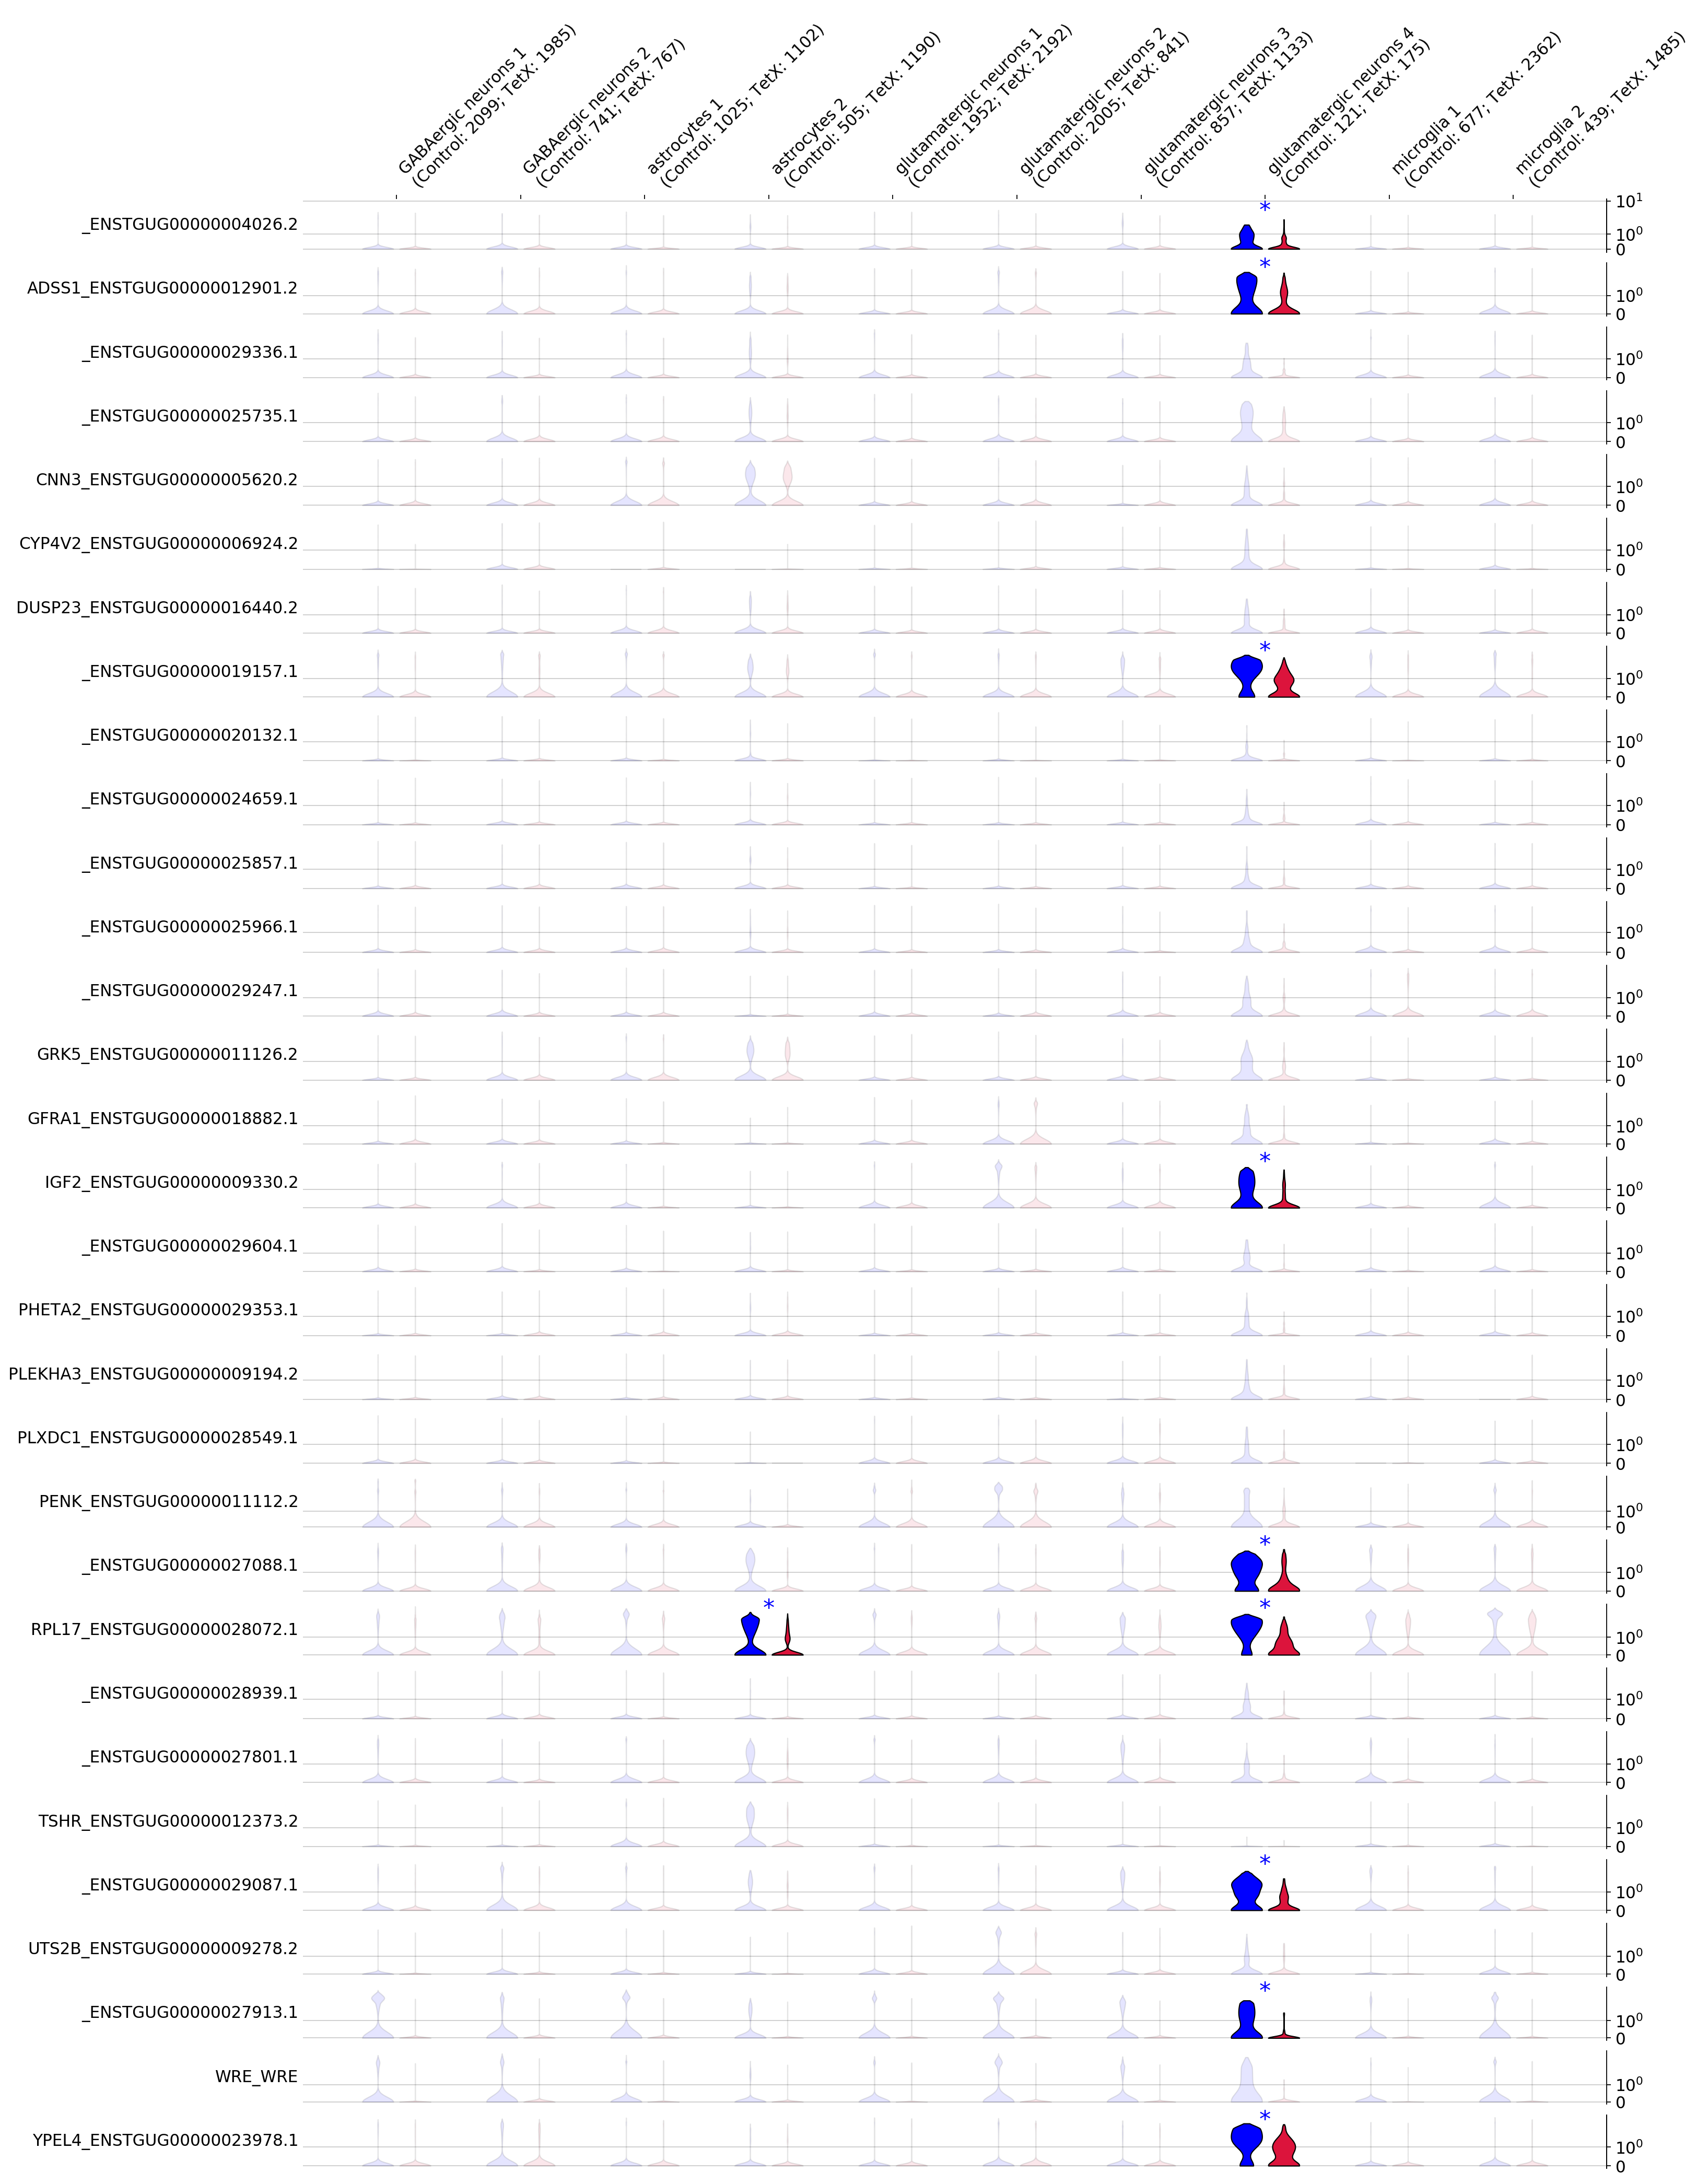

In [22]:
genes = df_DE_ctrl["gene_ID"].values
labels = df_DE_ctrl["gene_ID"].values
celltypes = clusters

ax = violinplot(
    adata_exp,
    adata_ctrl,
    genes,
    labels,
    celltypes,
    fig_name="DE_CTRL_individual-clusters_wilcoxon",
    fold_change_min=1.5,
)

# Conclusion: Wilcoxon gave the exact same genes as t-test on the DE gene analsysis for genes that are higher in control. If I compute the fold change using the median instead of the mean gene expression, almost all genes are non-significant (theshold fold change > 1.5).

Plot genes that are higher in experiment:

In [ ]:
# genes = df_DE_exp["gene_ID"].values
# labels = df_DE_exp["gene_name"].values
# celltypes = clusters

# violinplot(
#     adata_exp,
#     adata_ctrl,
#     genes,
#     labels,
#     celltypes,
#     fig_name="DE_EXP_individual-clusters",
#     fold_change_min=1.5,
# )

In [19]:
## DE genes if clusters with < 100 cells are also taken into account and only first 20 DE genes are kept:
# ctrl_gene_names = [
#     "ENSTGUG00000027913\n (novel protein-coding gene)",
#     "Proteasome Subunit Beta 5-like (PSMB5)",
#     "Tubulin Beta 7 chain (TUBB7)",
#     "Asparagine Synthetase Domain containing 1 (ASNSD1)",
#     "ENSTGUG00000019465\n (lncRNA)",
#     "ENSTGUG00000026317\n (lncRNA)",
#     "Ribosome Production Factor 2 Homolog (RPF2)",
#     "ENSTGUG00000028085\n (lncRNA)",
#     "ENSTGUG00000025142\n (novel protein-coding)",
#     "ENSTGUG00000025767\n (lncRNA)",
#     "Optic atrophy 3 (OPA3) protein homolog",
#     "Ribosomal Protein L17 (RPL17)",
#     "Thyroid Stimulating Hormone Receptor (TSHR)",
#     "ENSTGUG00000027801\n (novel protein-coding)",
#     "WRE",
#     "Insulin Like Growth Factor 2 (IGF2)",
#     "All-Trans Retinoic Acid Induced Differentiation factor (ATRAID)",
#     "Actin, cytoplasmic type 5",
#     "G Protein Subunit Gamma 4 (GNG4)",
#     "Solute Carrier Family 6 Member 19 (SLC6A19)",
#     "Polypeptide N-Acetylgalactosaminyltransferase 4 (GALNT4)",
#     "Toll Interacting Protein (TOLLIP)",
#     "YY1 Associated Factor 2 (YAF2)",
#     "Dynein Cytoplasmic 1 Intermediate Chain 2 (DYNC1I2)",
#     "G Protein Subunit Gamma 7 (GNG7)",
#     "Ubiquitin C-Terminal Hydrolase L1 (UCHL1)",
#     "Frataxin (FXN)",
#     "NSE2 (MMS21) Homolog (NSMCE2)",
#     "RNA Polymerase II CTD Phosphatase (SSU72 Homolog)"
# ]
    
# df_DE_ctrl = pd.DataFrame()
# df_DE_ctrl["gene_ID"] = DE_ctrl
# df_DE_ctrl["gene_name"] = ctrl_gene_names
# # # Sort gene alphabetically 
# # df_DE_ctrl = df_DE_ctrl.sort_values("gene_name")
# df_DE_ctrl